<a href="https://colab.research.google.com/github/PRaezUC3M/cohort_selection/blob/master/CNN_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount the drive folder**

**Load the train and test csv files**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **Configurartion of the experiments**
The different possible experiments have been automated. It is inspired in grid-search, and the parameters must be expressed in array-like style. You can find an example below.

In [0]:
# Baseline Model
num_classes = 13

embeddings_size = [200]
conv_size = [128]
conv_filter = [4]
dropout = [0.1]
fnn_size = [conv_size[-1] // 2, num_classes]

In [2]:
import pandas as pd
import numpy as np

SST_HOME='drive/My Drive/Colab Notebooks/CohortSelection/'

def load_train():
  path_train=SST_HOME+'data/train/train.csv'
  train = pd.read_csv(path_train,header=0, delimiter="\t", quoting=3)

  categories=train.columns[2:]

  texts = train[['TEXT']].as_matrix()
  train_x = [x[0].strip() for x in texts.tolist()]

  #we only keep the columns with the categories.
  train_y = train.drop(['IDFILE', 'TEXT'], axis=1).as_matrix()


  print('training loaded')
  
  return train_x, train_y, categories

def load_test():
  path_test=SST_HOME+'data/test/test.csv'
  test = pd.read_csv(path_test,header=0, delimiter="\t", quoting=3)
  #gets the ids
  idFiles = test[['IDFILE']].as_matrix().tolist()
  #gets the texts
  texts = test[['TEXT']].as_matrix()
  test_x = [x[0].strip() for x in texts.tolist()]
  #gets the labels
  test_y = test.drop(['IDFILE', 'TEXT'], axis=1).as_matrix()

  print('testing dataset loaded')
  
  return test_x, test_y, idFiles
  
train_x, train_y, categories = load_train()
test_x, test_y, idFiles = load_test()

training loaded
testing dataset loaded


# **Oversampling**

As the dataset is very unbalanced, we must perform over-sampling (which is to increase the minority class(es)). The RandomOverSampler **class** allows us to over-sample minority classes by  picking samples at random with replacement. We need to install the package **imbalanced-learn**.


In [3]:
!pip3 install -U imbalanced-learn

    100% |████████████████████████████████| 174kB 7.0MB/s 
    100% |████████████████████████████████| 5.4MB 7.6MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2


In [0]:
# Imports
from imblearn.over_sampling import RandomOverSampler

In [5]:
train_y[0]

multilabel_multiclass_y = np.array([[(index + 1) for index, value in enumerate(y) if not value == 0] for y in train_y])
multilabel_multiclass_y[:10]

array([list([1, 3, 4, 6, 7, 8, 10, 12]), list([1, 2, 3, 4, 8, 10]),
       list([1, 4, 6, 8, 10, 12]), list([1, 8, 10, 11]),
       list([1, 3, 4, 6, 8, 9, 10, 12]), list([1, 2, 4, 8, 10]),
       list([1, 2, 3, 8, 10, 12]), list([1, 4, 6, 8, 10, 12]),
       list([1, 2, 3, 4, 6, 7, 8, 10]), list([1, 3, 4, 6, 8, 10, 12, 13])],
      dtype=object)

In [8]:
any([len(i) == 0 for i in multilabel_multiclass_y])
len(np.where(~train_y.any(axis=1))[0])

0

In [0]:
ros = RandomOverSampler(random_state=9000)
X_resampled, Y_resampled = ros.fit_resample(train_x_token, train_y.astype(np.float64))

assert Y_resampled.shape[1] == train_y.shape[1]
"""Compare both datasets (before oversampling) and after sampling)"""

# Check Y_resampled has the same lables
assert Y_resampled.shape[1] == train_y.shape[1]

import seaborn as sns

fig = plt.figure(figsize=(20,20))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=train_y.sum(axis=0), y=categories, ax=ax_test)
g2 = sns.barplot(x=Y_resampled.sum(axis=0), y=categories, ax=ax_train)
g1.set_title("class distribution before resampling")
g2.set_title("class distribution in training set after resampling")

AssertionError: ignored

#**Balancing the categories**
We can see that there are some categories way more present than others in our dataset. Let's sort them.

[185  88 121 141   1 129  77 222   8 219  14  91  20]


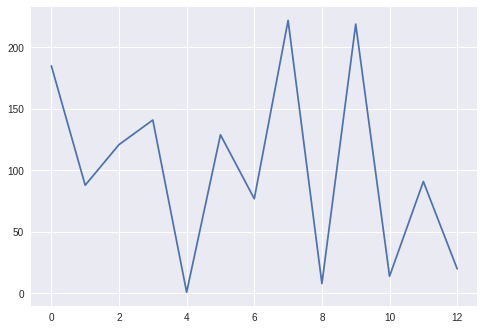

In [0]:
classes = np.add(sum(train_y), sum(test_y))
import matplotlib.pyplot as plt
print(classes)
plt.plot(classes)

Now we can see the differences in a easier way, we will add weights to the different classes, based on how present they are in the dataset.

In [0]:
total_cases = sum(classes)
class_weight = [1 / (c/total_cases) for c in classes]

# **Tokenize the dataset and use the word embeddings**

This shows the set of different words ordered by frequency. *tokenizer.word_index*

The text is tokenized and cleaned of stop-words as well as punctuation signs. Also the numbers are substituted by a token "nmbr"

We crop the beggining of the examples because it is the date when they
were written down.

Finally, and after being tokenized, the different sentences are padded to match the maximum length.

max_length == 7813 it is really a huge vector because we have to pad
it afterwards, in order to get it into the CNN

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=stopwords.words('english')

MAX_WORDS = 5000

# Defined from the dataset itself.
DATE_LENGTH = 23

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### CNN Input

Here we take a maximum length of file by obtaining the accumulative density distribution of the training examples. This way we can see how many examples fall under certain threshold. Which will be fixed to 80% of the total examples. This length is 5000 words roughly.

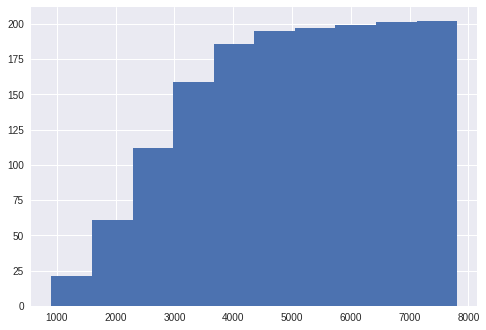

In [0]:
cropped_date_text = [sentence[DATE_LENGTH:] for sentence in train_x]
lenghts = [len(sentence[DATE_LENGTH:].split(" ")) for sentence in cropped_date_text]
plt.hist(lenghts, cumulative=True)

# Set the maximum phrase size as 5000
max_length = 5000

In [0]:
# We are using this function to clean the test set
def tokenize_clean_text(text, tokenizer=None, max_length=None, 
                        max_words=MAX_WORDS, date_length=DATE_LENGTH):
  """
  This function is in charge of tokenizing the text it is given. It also cleans
  the text from stop-words, punctuation, and gives a special token to numbers.
  
  :param text: The texts to tokenize in a bidimensional python array.
  
  :returns: The tokenized and cleaned text in a bidimensional python array.
            The tokenizer used to preprocess the text.
            The maximum length used for padding.
  """  
  # Consider to stemm or lemmatize the text 
  
  cropped_date_text = [sentence[date_length:] for sentence in text]

  if max_length == None:
    # We get the maximum token length by splitting by spaces
    max_length = max([len(sentence[date_length:].split(" ")) for sentence in cropped_date_text])
    
  # We substitute the numbers by a token "nmbr" 
  cropped_date_numbers_text = [" ".join([word if not word.isdigit() else "nmbr"
                                for word in sentence.split()])
                               for sentence in cropped_date_text]
  
  # Delete stopwords as well as every word less than 3 chars.
  cropped_date_numbers_stopw_text = [" ".join([word if not (word in stop_words or len(word) <= 3) else ""
                                      for word in sentence.split()])
                                     for sentence in cropped_date_numbers_text]
  
  if tokenizer is None:
    tokenizer = Tokenizer(num_words=MAX_WORDS) # They use 5k words too
    tokenizer.fit_on_texts(cropped_date_numbers_stopw_text)
  # We tokenize the sentences
  tokenized_text = tokenizer.texts_to_sequences(cropped_date_numbers_stopw_text)
  
  # Now we return the padded the sequences.
  return pad_sequences(tokenized_text, max_length), tokenizer, max_length
  

In [0]:
train_x_token, tokenizer, max_length = tokenize_clean_text(train_x, max_length=max_length)
test_x_token, _, _ = tokenize_clean_text(test_x, tokenizer, max_length)
assert len(train_x_token) == len(train_x)
assert len(test_x_token) == len(test_x)

# **TensorBoard**
TensorBoard is a great tool for DL visualization. It shows the evolution of metrics during the training phase, as well as the weights, distributions, and even the graph of the neural net. 

We will be using tensorboardcolab in order to run a 
TensorBoard instance. This will initialize a ngrok machine and launch TensorBoard for us to see. 

TensorBoard will be accesible by the url 

In [0]:
# We install tensorboard colab in case we don't have it already.
!pip install tensorboardcolab

In [0]:
import tensorboardcolab as tb

tbc=tb.TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://25c82e5b.ngrok.io


#**Create a keras Embedding model**

In this section we will create a Keras CNN model, compile, and train it.

In this model we also generate the different embeddings for the words by using the Embedding Keras layer.  

Some information about the architecture of the net is shown bellow. 

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

In [0]:
# Network parameters

embedding_dim = 300
filter_length = 128
window_size = 3
dropout = 0.1
num_classes = len(train_y[0])
fnn = [filter_length//2, num_classes]

In [0]:
# Generate the sequential baseline model
model = Sequential()
model.add(Embedding(MAX_WORDS, embedding_dim, input_length=max_length))
model.add(Dropout(dropout))
model.add(Conv1D(filter_length, window_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(filter_length//2))
model.add(Dropout(dropout))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=["categorical_accuracy"])

# Print a summary of it.
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 300)         1500000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4998, 128)         115328    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                845       
__________

In [0]:
# Define the callbacks
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    tb.TensorBoardColabCallback(tbc)
]

In [0]:
# Fit the model and extract its data
history = model.fit(train_x_token, train_y, epochs=20, batch_size=32, 
                    class_weight=class_weight, callbacks=callbacks,
                    validation_data=(test_x_token, test_y))

# Set a name for the model based on the tweaked parameters
name = "embedding_{}_dropout_{}_n-grams_{}_filter_len_{}_fnn_{}".format(embedding_dim, dropout, window_size, filter_length, fnn)
# And save the model
model.save(SST_HOME+"DL/models/" + name)

Epoch 1/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0763 - categorical_accuracy: 0.1931
Epoch 2/20
 32/202 [===>..........................] - ETA: 0s - loss: 0.0743 - categorical_accuracy: 0.2188

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


202/202 [==============================] - 1s 5ms/step - loss: 0.0651 - categorical_accuracy: 0.1683
Epoch 3/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0529 - categorical_accuracy: 0.1535
Epoch 4/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0482 - categorical_accuracy: 0.2079
Epoch 5/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0397 - categorical_accuracy: 0.1881
Epoch 6/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0333 - categorical_accuracy: 0.1931
Epoch 7/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0305 - categorical_accuracy: 0.2327
Epoch 8/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0253 - categorical_accuracy: 0.2426
Epoch 9/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0212 - categorical_accuracy: 0.1683
Epoch 10/20
202/202 [==============================] - 1s 5ms/step - loss: 0.0211 - categorical_accuracy: 0.1337
Ep

In [0]:
from sklearn.metrics import classification_report
print("Applying best classifier on test data:")

predictions = model.predict(test_x_token)
predictions = np.array([[0 if value < 0.5 else 1 for value in prediction] for prediction in predictions])

# measuring performance on test set
cr=classification_report(test_y, predictions, target_names=categories.values)
print(cr)


Applying best classifier on test data:
                 precision    recall  f1-score   support

     ASP-FOR-MI       0.77      1.00      0.87        23
      ABDOMINAL       0.75      0.27      0.40        11
  DIETSUPP-2MOS       0.64      0.56      0.60        16
   ADVANCED-CAD       0.54      0.81      0.65        16
       KETO-1YR       0.00      0.00      0.00         0
 MAJOR-DIABETES       0.60      0.75      0.67        16
          HBA1C       0.43      0.30      0.35        10
MAKES-DECISIONS       0.93      1.00      0.97        28
  ALCOHOL-ABUSE       0.00      0.00      0.00         1
        ENGLISH       0.90      1.00      0.95        27
     DRUG-ABUSE       0.00      0.00      0.00         2
     CREATININE       0.67      0.44      0.53         9
        MI-6MOS       0.00      0.00      0.00         2

    avg / total       0.72      0.76      0.72       161



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#**Generating output in XML format**



In [0]:
import xml.etree.ElementTree
NOT='not met'
MET='met'

#gets a idFile, a dictionary with the predictions (category, label) and the name of the classifier used.
def outputToXML(idFile,dictPred,classifier):
    
    path=SST_HOME+'data/test/xml/'+idFile+'.xml'
    
    output=SST_HOME+'data/output/'+classifier+'/'+idFile+'.xml'
    
   
    et = xml.etree.ElementTree.parse(path)

    new_tag = xml.etree.ElementTree.SubElement(et.getroot(), 'TAGS')
    
    for cat in dictPred.keys():
        element = xml.etree.ElementTree.SubElement(new_tag, cat)    
        if dictPred[cat]==0:
            element.attrib['met'] = NOT 
        else:
            element.attrib['met'] = MET

    et.write(output)

#function for creating a dictionary with the categories with values 0 or 1
def iniDictPred(labels):
    
    if len(labels)!=len(categories):
        print('Warning!!!')
        return None
    
    dictPred={}
    i=0
    
    for x in categories:
        dictPred[x]=labels[i]
        i=i+1
    return dictPred
  

print('functions to generate XML files loaded!')

functions to generate XML files loaded!


In [0]:
#creates the output xml files
dictionary = zip(idFiles, predictions)
for obj in dictionary:
    idFile=str(obj[0][0])
    labels=obj[1] #gets their predictions for this file
    dictPred=iniDictPred(labels) #creates a dictionary to join categories and labels 0,1
    outputToXML(idFile,dictPred,"CNN")

print('output xml files were generated!')

output xml files were generated!


In [0]:
# We move to the main folder and execute the tests
!cd "drive/My Drive/Colab Notebooks/CohortSelection/" && python3 track1_eval.py data/test/gold data/output/CNN >> "drive/My Drive/Colab Notebooks/CohortSelection/"

******************************************* TRACK 1 ********************************************
                      ------------ met -------------    ------ not met -------    -- overall ---
                      Prec.   Rec.    Speci.  F(b=1)    Prec.   Rec.    F(b=1)    F(b=1)  AUC   
           Abdominal  0.5000  0.4545  0.7368  0.4762    0.7000  0.7368  0.7179    0.5971  0.5957
        Advanced-cad  0.8667  0.8125  0.8571  0.8387    0.8000  0.8571  0.8276    0.8331  0.8348
       Alcohol-abuse  0.0000  0.0000  1.0000  0.0000    0.9667  1.0000  0.9831    0.4915  0.5000
          Asp-for-mi  0.7308  0.8261  0.0000  0.7755    0.0000  0.0000  0.0000    0.3878  0.4130
          Creatinine  0.4444  0.4444  0.7619  0.4444    0.7619  0.7619  0.7619    0.6032  0.6032
       Dietsupp-2mos  0.6500  0.8125  0.5000  0.7222    0.7000  0.5000  0.5833    0.6528  0.6562
          Drug-abuse  0.0000  0.0000  1.0000  0.0000    0.9333  1.0000  0.9655    0.4828  0.5000
             English  0.9000  

# **Generating a Keras model**

In this case we still generate a model but will not train the word embeddings. Instead we will use the _"wikipedia-pubmed-and-PMC"_ word embeddings, which are already trained.

In order to do so, we will have to perform a few additional steps before inputting the data to the network.

### Load the embeddings

In this step, we load the word embeddings from the wikipedia, pubmed and PMC. Then we filter them adapting to the words we have in our dataset. This is, if the word appears in the pubmed we take its weights, which are set to 0 otherwise.

In [0]:
# seemingly gensim is not installed in google colab
!pip install gensim

In [0]:
from gensim.models.keyedvectors import KeyedVectors

PATH_W2V = "drive/My Drive/Colab Notebooks/CohortSelection/DL/word2vect/wikipedia-pubmed-and-PMC-w2v.bin"

In [0]:
# Network parameters

embedding_dim = 200 # The model has that dimmensions
filter_length = 128
window_size = 4
dropout = 0.1
num_classes = len(train_y[0])
fnn = [filter_length//2, num_classes]

In [0]:
def load_W2V_model(path):
    model = KeyedVectors.load_word2vec_format(path, binary=True)
    print("Loaded W2V model")
    return model

In [0]:
model = load_W2V_model(PATH_W2V)

Loaded W2V model


In [0]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim), dtype=np.float32)
for word, i in word_index.items():
  if i >= MAX_WORDS:
      break
  if word in model:
      # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = model[word]
        
print(len(embedding_matrix))

5000


### Generate the model using the embeddings

Here we will generate the model by using the embeddings provided and setting that layer to not be trained.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

In [0]:
# Generate the sequential baseline model
model = Sequential()
model.add(Embedding(MAX_WORDS, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(Dropout(dropout))
model.add(Conv1D(filter_length, window_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(filter_length//2))
model.add(Dropout(dropout))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", 
              metrics=["binary_accuracy",
                       "categorical_accuracy"])

# Print a summary of it.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 5000, 200)         1000000   
_________________________________________________________________
dropout_27 (Dropout)         (None, 5000, 200)         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 4997, 128)         102528    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 13)                845       
__________

In [0]:
# Define the callbacks
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    tb.TensorBoardColabCallback(tbc)
]

In [0]:
# Fit the model and extract its data
history = model.fit(train_x_token, train_y, epochs=20, batch_size=32, 
                    class_weight=class_weight, callbacks=callbacks,
                    validation_data=(test_x_token, test_y))

# Set a name for the model based on the tweaked parameters
name = "embedding_{}_dropout_{}_n-grams_{}_filter_len_{}_fnn_{}".format(embedding_dim, dropout, window_size, filter_length, fnn)
# And save the model
model.save(SST_HOME+"DL/models/" + name)

Train on 202 samples, validate on 30 samples
Epoch 1/20
202/202 [==============================] - 1s 5ms/step - loss: 0.5126 - binary_accuracy: 0.7407 - categorical_accuracy: 0.3812 - val_loss: 0.4712 - val_binary_accuracy: 0.7308 - val_categorical_accuracy: 0.0000e+00
Epoch 2/20
202/202 [==============================] - 1s 3ms/step - loss: 0.4523 - binary_accuracy: 0.7631 - categorical_accuracy: 0.0149 - val_loss: 0.4560 - val_binary_accuracy: 0.7795 - val_categorical_accuracy: 0.0000e+00
Epoch 3/20
202/202 [==============================] - 1s 3ms/step - loss: 0.4304 - binary_accuracy: 0.7795 - categorical_accuracy: 0.0149 - val_loss: 0.4491 - val_binary_accuracy: 0.7744 - val_categorical_accuracy: 0.0000e+00
Epoch 4/20
202/202 [==============================] - 1s 3ms/step - loss: 0.4170 - binary_accuracy: 0.7928 - categorical_accuracy: 0.0099 - val_loss: 0.4453 - val_binary_accuracy: 0.7872 - val_categorical_accuracy: 0.0000e+00
Epoch 5/20
202/202 [==============================]

In [0]:
from sklearn.metrics import classification_report
print("Applying best classifier on test data:")

predictions = model.predict(test_x_token)
predictions = np.array([[0 if value < 0.5 else 1 for value in prediction] for prediction in predictions])

# measuring performance on test set
cr=classification_report(test_y, predictions, target_names=categories.values)
print(cr)


Applying best classifier on test data:
                 precision    recall  f1-score   support

     ASP-FOR-MI       0.77      1.00      0.87        23
      ABDOMINAL       0.50      0.45      0.48        11
  DIETSUPP-2MOS       0.68      0.81      0.74        16
   ADVANCED-CAD       0.65      0.81      0.72        16
       KETO-1YR       0.00      0.00      0.00         0
 MAJOR-DIABETES       0.64      0.88      0.74        16
          HBA1C       0.67      0.20      0.31        10
MAKES-DECISIONS       0.93      1.00      0.97        28
  ALCOHOL-ABUSE       0.00      0.00      0.00         1
        ENGLISH       0.90      1.00      0.95        27
     DRUG-ABUSE       0.00      0.00      0.00         2
     CREATININE       0.62      0.56      0.59         9
        MI-6MOS       0.00      0.00      0.00         2

    avg / total       0.73      0.81      0.75       161



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
import xml.etree.ElementTree
NOT='not met'
MET='met'

#gets a idFile, a dictionary with the predictions (category, label) and the name of the classifier used.
def outputToXML(idFile,dictPred,classifier):
    
    path=SST_HOME+'data/test/xml/'+idFile+'.xml'
    
    output=SST_HOME+'data/output/'+classifier+'/'+idFile+'.xml'
    
   
    et = xml.etree.ElementTree.parse(path)

    new_tag = xml.etree.ElementTree.SubElement(et.getroot(), 'TAGS')
    
    for cat in dictPred.keys():
        element = xml.etree.ElementTree.SubElement(new_tag, cat)    
        if dictPred[cat]==0:
            element.attrib['met'] = NOT 
        else:
            element.attrib['met'] = MET

    et.write(output)

#function for creating a dictionary with the categories with values 0 or 1
def iniDictPred(labels):
    
    if len(labels)!=len(categories):
        print('Warning!!!')
        return None
    
    dictPred={}
    i=0
    
    for x in categories:
        dictPred[x]=labels[i]
        i=i+1
    return dictPred
  

print('functions to generate XML files loaded!')

functions to generate XML files loaded!


In [0]:
#creates the output xml files
dictionary = zip(idFiles, predictions)
for obj in dictionary:
    idFile=str(obj[0][0])
    labels=obj[1] #gets their predictions for this file
    dictPred=iniDictPred(labels) #creates a dictionary to join categories and labels 0,1
    outputToXML(idFile,dictPred,"CNN_Embedding")

print('output xml files were generated!')

output xml files were generated!


In [0]:
# We move to the main folder and execute the tests
!cd "drive/My Drive/Colab Notebooks/CohortSelection/" && python3 track1_eval.py data/test/gold data/output/CNN_Embedding

******************************************* TRACK 1 ********************************************
                      ------------ met -------------    ------ not met -------    -- overall ---
                      Prec.   Rec.    Speci.  F(b=1)    Prec.   Rec.    F(b=1)    F(b=1)  AUC   
           Abdominal  0.5000  0.4545  0.7368  0.4762    0.7000  0.7368  0.7179    0.5971  0.5957
        Advanced-cad  0.6500  0.8125  0.5000  0.7222    0.7000  0.5000  0.5833    0.6528  0.6562
       Alcohol-abuse  0.0000  0.0000  1.0000  0.0000    0.9667  1.0000  0.9831    0.4915  0.5000
          Asp-for-mi  0.7667  1.0000  0.0000  0.8679    0.0000  0.0000  0.0000    0.4340  0.5000
          Creatinine  0.6250  0.5556  0.8571  0.5882    0.8182  0.8571  0.8372    0.7127  0.7063
       Dietsupp-2mos  0.6842  0.8125  0.5714  0.7429    0.7273  0.5714  0.6400    0.6914  0.6920
          Drug-abuse  0.0000  0.0000  1.0000  0.0000    0.9333  1.0000  0.9655    0.4828  0.5000
             English  0.9000  